# 4.1 선형 회귀


## matplotlib에서 한글 쓰기

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#마이너스 폰트가 깨지는 것을 막기 위해


In [2]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

버전:  3.3.3
설치 위치:  C:\Users\sarah\Anaconda3\lib\site-packages\matplotlib\__init__.py
설정 위치:  C:\Users\sarah\.matplotlib
캐시 위치:  C:\Users\sarah\.matplotlib


In [3]:
print ('설정파일 위치: ', mpl.matplotlib_fname())

설정파일 위치:  C:\Users\sarah\Anaconda3\lib\site-packages\matplotlib\mpl-data\matplotlibrc


In [4]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

In [5]:
# ttf 폰트 전체 갯수
f = [f.name for f in fm.fontManager.ttflist]
print(len(font_list))

# 10개의 폰트명 만 출력
f[:10]

1446


['DejaVu Sans',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'cmb10',
 'STIXSizeFourSym',
 'cmr10',
 'DejaVu Sans Mono',
 'cmmi10',
 'DejaVu Serif',
 'DejaVu Sans Display']

In [6]:
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

[('Nanum YeorIrCe',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손글씨 열일체.ttf'),
 ('Nanum SaRangHaeADeur',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손글씨 사랑해 아들.ttf'),
 ('Nanum HyoNamNeurHwaITing',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손글씨 효남 늘 화이팅.ttf'),
 ('Nanum JeongEunCe',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손글씨 정은체.ttf'),
 ('Nanum MongDor',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손글씨 몽돌.ttf'),
 ('Nanum HarABeoJiEuiNaNum',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손글씨 할아버지의나눔.ttf'),
 ('Nanum MasIssNeunCe',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손글씨 맛있는체.ttf'),
 ('Nanum MuGungHwa',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손글씨 무궁화.ttf'),
 ('NanumGothic', 'C:\\Windows\\Fonts\\NanumGothicLight.ttf'),
 ('Nanum GimYuICe',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손

('NanumGothicCoding',
  'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicCoding.ttf')

In [7]:
#fontprop 각각 설정해서 할 수 있는 코드
path = 'C:\\Users\\sarah\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicCoding.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

#또는 한 번에 설정하는 코드
plt.rcParams["font.family"] = 'NanumGothicCoding'

## 4.1.1 정규방정식

[참고](https://github.com/rickiepark/handson-ml2/blob/master/04_training_linear_models.ipynb)

In [8]:
import numpy as np

X = 2*np.random.rand(100,1)
y = 4 + 3*X + np.random.randn(100,1)

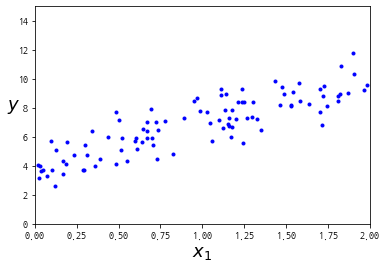

In [9]:
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

무작위로 생성한 선형 데이터셋

In [10]:
#모든 샘플에 x0=1을 추가 
X_b = np.c_[np.ones( (100,1) ), X] #np.c_ : column stack
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) 
#np.linalg : linear algebra, inv() : inverse matrix, dot() : dot product

In [11]:
print(theta_best)

[[3.95954738]
 [3.01717587]]


의도한 바는 4와 3이었는데 잡음 때문에 정확하게 예측하지 못함.

In [12]:
#theta hat을 이용하여 예측

X_new = np.array([ [0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new] #모든 샘플에 x0=1을 추가
y_predict =  X_new_b.dot(theta_best)
y_predict

array([[3.95954738],
       [9.99389912]])

<function matplotlib.pyplot.show(close=None, block=None)>

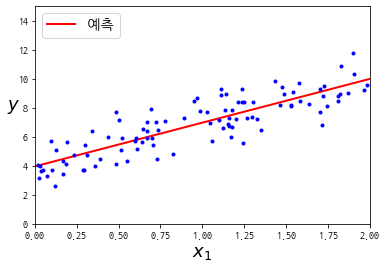

In [13]:
plt.rcParams["font.family"] = 'NanumGothicCoding'

plt.plot(X_new, y_predict, "r-", linewidth=2, label="예측")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show

In [14]:
#사이킷런에서 선형 회귀하기
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.95954738]), array([[3.01717587]]))

In [15]:
lin_reg.predict(X_new)

array([[3.95954738],
       [9.99389912]])

Linear Regression 클래스는 scipy.linalg.lstsq() 함수(least square)를 기반으로 함.

In [16]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6) #rcond : 작은 특이값에 대한 차단 비율
theta_best_svd #svd : singular value decomposition

array([[3.95954738],
       [3.01717587]])

$ 
\bf{\hat{\bf{\theta}} } = \bf{X}^+ \bf{y}
$
를 계산. $ \bf {X}^+  $ 는 유사역행렬(pseudo inverse, Moore-Penrose inverse).

In [17]:
np.linalg.pinv(X_b).dot(y)

array([[3.95954738],
       [3.01717587]])

# 4.2 경사 하강법
## 4.2.1 배치 경사 하강법

In [18]:
eta = 0.1 #learning rate
n_iterations = 1000 #iteration : 되풀이
m = 100

theta = np.random.randn(2,1) #무작위 초기화

for iteration in range(n_iterations) :
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients

print(theta)

[[3.95954738]
 [3.01717587]]


In [19]:
theta_path_bgd = [] #?????

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

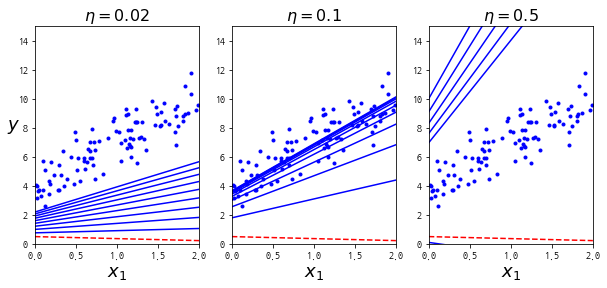

In [20]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

빨간 점선부터 시작해서 파란 점들로 가고 싶은 것임.

왼쪽은 너무 느리고, 오른쪽은 너무 커서 발산해버림. 가운데가 가장 적절.

## 4.2.2 확률적 경사 하강법

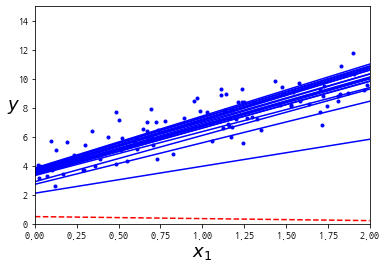

In [21]:
n_epochs = 50
t0, t1 = 5, 50 #learning schedule parameter

def learning_schedule(t) :
    return t0/(t + t1)

theta = np.random.randn(2,1) #무작위 초기화

theta_path_sgd = []

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization


for epoch in range(n_epochs) :
    for i in range(m) : 
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index +1]
        yi = y[random_index : random_index +1]
        gradients = 2*xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m + i)
        theta = theta - eta*gradients
        theta_path_sgd.append(theta) 
        
plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                                
plt.show()                

In [22]:
theta

array([[3.94877669],
       [3.06284684]])

In [23]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [24]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.01044754]), array([3.10446572]))

# 4.3 다항 회귀

In [25]:
m = 100
X = 6*np.random.rand(m, 1) - 3
y = 0.5*X**2 + X + 2 + np.random.randn(m, 1)

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([1.97322766])

In [28]:
X_poly[0]

array([1.97322766, 3.89362739])

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.19573036]), array([[1.00978737, 0.4681429 ]]))

C:\Users\sarah\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sarah\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


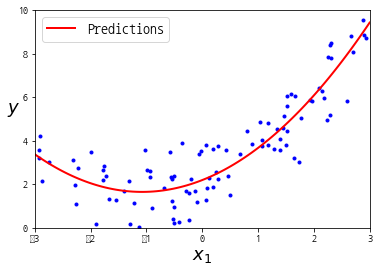

In [31]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10]) #????? 마이너스가 왜 깨지지?
plt.show() 

# 4.4 학습 곡선

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y) :
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)) :
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")
    plt.legend(loc="upper right", fontsize=14) 

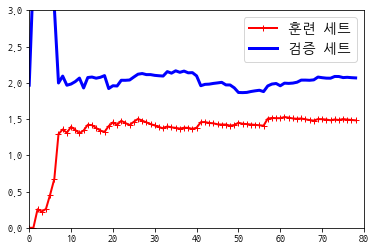

In [42]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

과소적합 모델의 전형적인 모습.

두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해있음.

과소적합일 때는 훈련 샘플을 더 추가해도 효과가 없음. 복잡한 모델을 사용하거나 나은 특성을 선택해야 함.

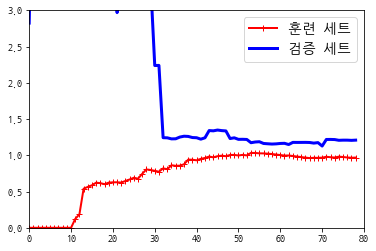

In [46]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

- 선형 회귀 모델보다 훈련 데이터의 오차가 낮다.
- 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다. (과대적합 모델의 특징)
- 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐. (검증 데이터의 성능이 좋아진다는 뜻)

# 4.5 규제가 있는 선형 모델

## 4.5.1 릿지 회귀

릿지(ridge) 회귀(티호노프(Tikhonov) 규제) : 규제가 추가된 선형 회귀 버전

릿지 회귀의 비용함수 : $ J( \bf{ \theta } ) = \text{MSE} ( \bf{ \theta } ) + \alpha \frac{1}{2} \sum _{i=1} ^n \theta _i ^2 $

In [47]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.02702991]])